# Validation, Regularisation and Callbacks

## Coding tutorials
#### [1. Validation sets](#coding_tutorial_1)
#### [2. Model regularisation](#coding_tutorial_2)
#### [3. Introduction to callbacks](#coding_tutorial_3)
#### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

del model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.tanh))
model.add(tf.keras.layers.Dense(units=2))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

history = model.fit(x=inputs, y=targets, validation_split=0.2)

# dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])
print(history.history.keys())

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
    verbose=0)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
    verbose=0)

#### Load the data

In [1]:
from sklearn.datasets import load_diabetes

# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])
print('\n', diabetes_dataset.keys())

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [2]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

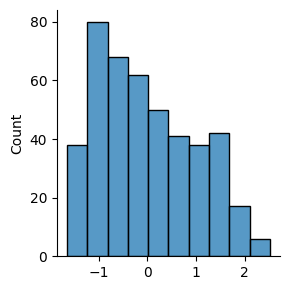

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Normalise the target data will make clearer training curves
targets = (targets - targets.mean(axis=0)) / targets.std()

sns.displot(x=targets, height=3)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Train target shape: {train_targets.shape}")
print(f"Test target shape: {test_targets.shape}")

Train data shape: (397, 10)
Test data shape: (45, 10)
Train target shape: (397,)
Test target shape: (45,)


#### Train a feedforward neural network model

In [15]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

# Build the model
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu,
        input_shape=(train_data.shape[1],)))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(units=128,
            activation=tf.keras.activations.relu))
    model.add(tf.keras.layers.Dense(units=1))
    
    return model

# Build model
model = get_model()
# Print the model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dense_19 (Dense)            (None, 128)               16512     
                                                                 
 dense_20 (Dense)            (None, 1)                

In [16]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

#### Plot the learning curves

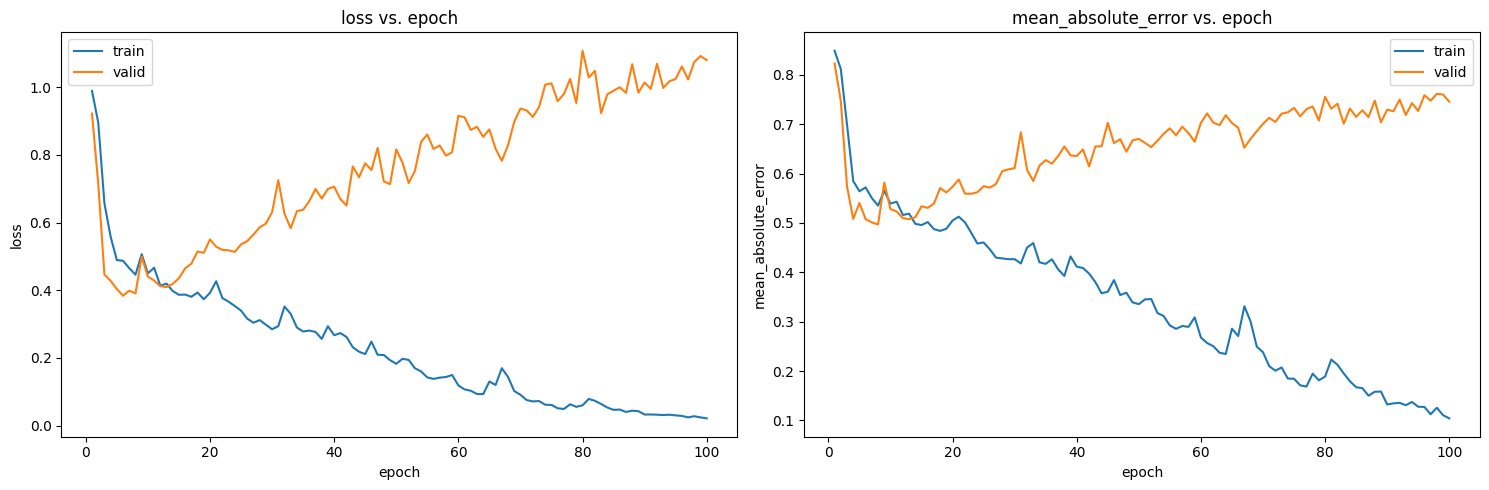

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the model, with some of the data reserved for validation
history = model.fit(x=train_data, y=train_targets, validation_split=0.15, 
    epochs=100, batch_size=64, verbose=0)

# Plot the training and validation loss
df_history = pd.DataFrame(data=history.history, index=history.epoch)
metrics = ['loss', 'mean_absolute_error']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
for ax, metric in zip(axes, metrics):
    sns.lineplot(ax=ax, data=df_history, label='train',
        x=df_history.index+1, y=metric)
    try:
        sns.lineplot(ax=ax, data=df_history, label='valid',
            x=df_history.index+1, y=f'val_{metric}')
    except Exception:
        pass
    ax.legend(loc='best')
    ax.set_xlabel(xlabel='epoch')
    ax.set_ylabel(ylabel=f'{metric}')
    ax.set_title(label=f'{metric} vs. epoch')
fig.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x=test_data, y=test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(test_loss, test_mae))

Test loss: 1.006
Test MAE: 0.778


***
<a id="coding_tutorial_2"></a>
## Model regularisation

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation="relu", 
        # kernel_regularizer=tf.keras.regularizers.l2(l2=0.001)
        # kernel_regularizer=tf.keras.regularizers.l1(l1=0.005)
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.001),
        bias_regularizer=tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[tf.keras.metrics.BinaryAccuracy()])

model.fit(inputs, targets, validation_split=0.25)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

# Training mode, with dropout
model.fit(inputs, targets, validation_split=0.25)
# Testing mode, no dropout
model.evaluate(val_inputs, val_targets)
# Testing mode, no dropout
model.predict(test_inputs)

#### Adding regularisation with weight decay and dropout

In [15]:
def get_regularised_model(input_shape, wd, rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd),
            input_shape=input_shape),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=128, activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l2(l2=wd)),
        tf.keras.layers.Dropout(rate=rate),
        tf.keras.layers.Dense(units=1)
    ])
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)              

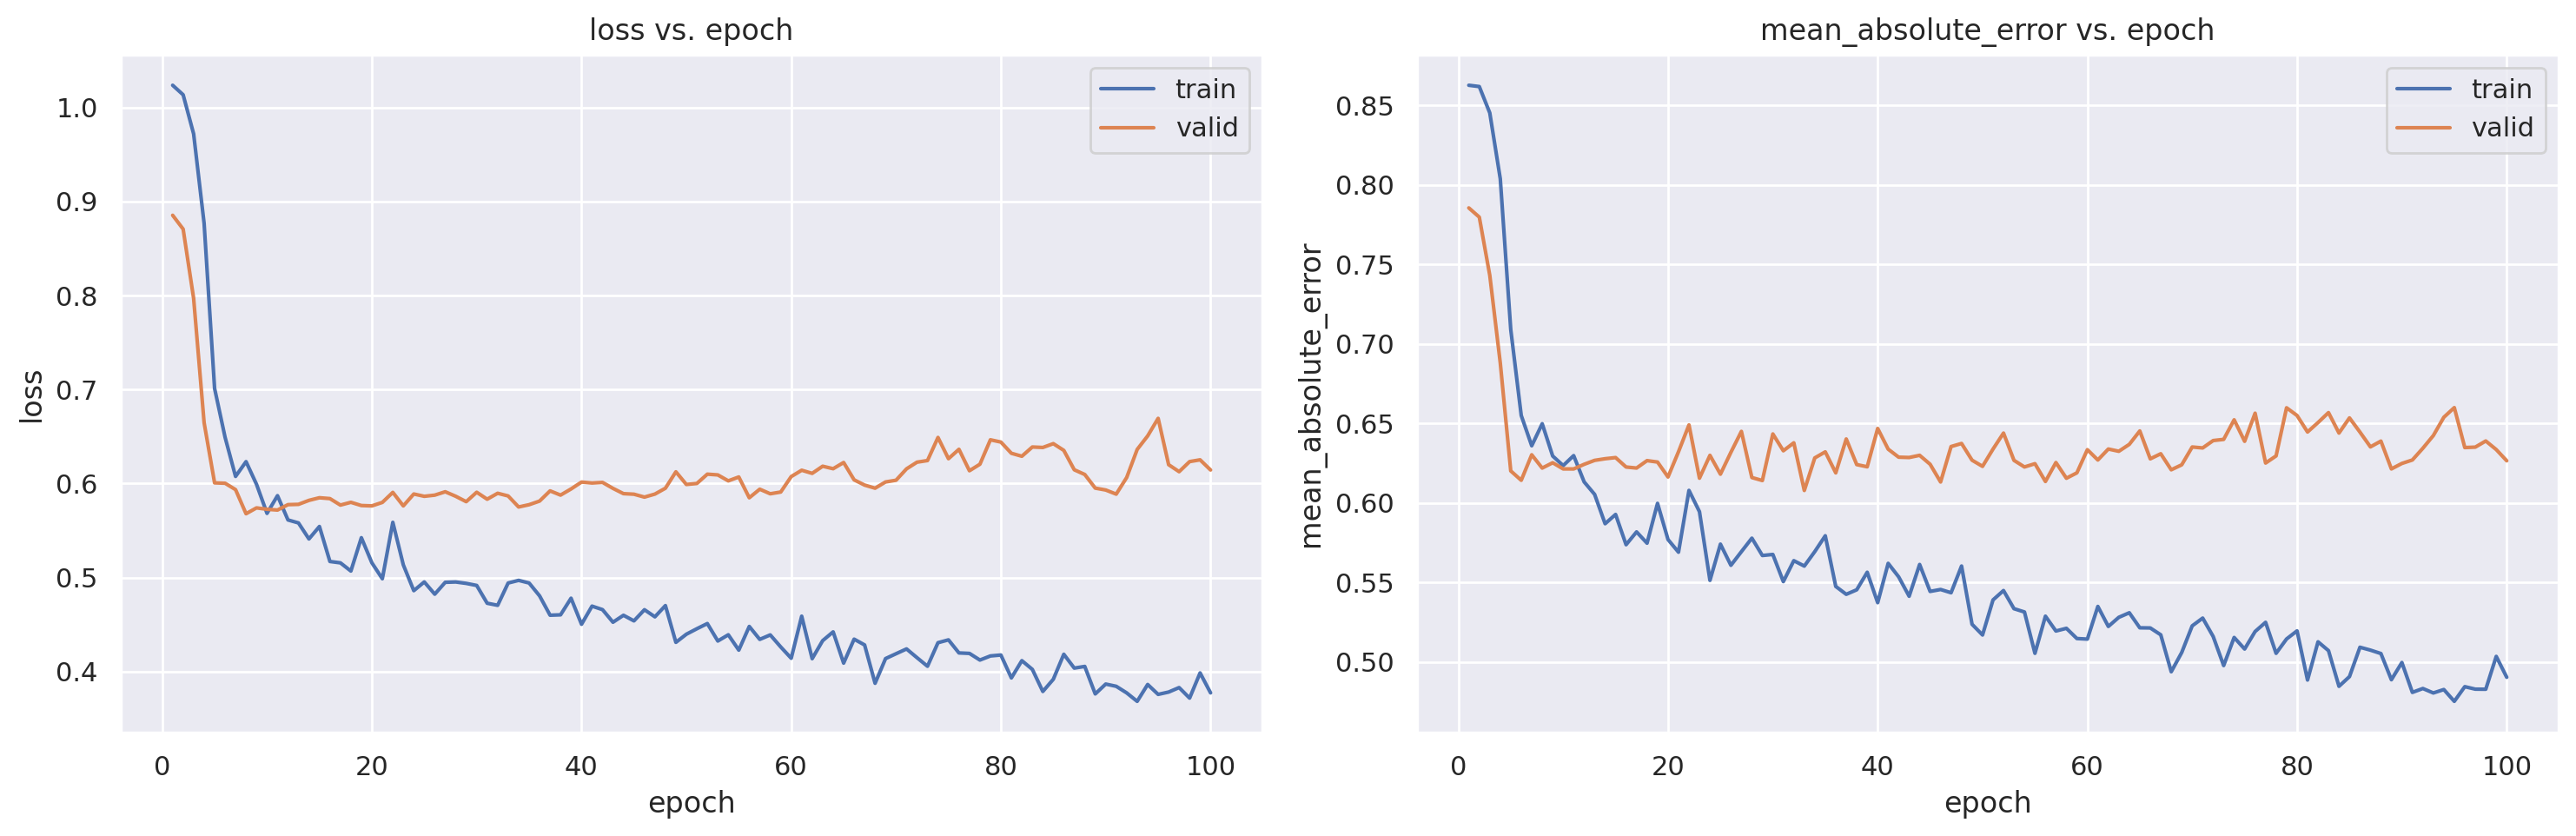

In [16]:
del model
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(input_shape=(train_data.shape[1],),
    wd=1e-5, rate=0.3)
print(model.summary())

# Compile the model
compile_model(model)
print(model.loss)
print(model.optimizer)
print(model.metrics)

# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, validation_split=0.15,
    epochs=100, batch_size=64, verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

In [17]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_data, test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

Test loss: 0.489
Test MAE: 0.509


#### Plot the learning curves

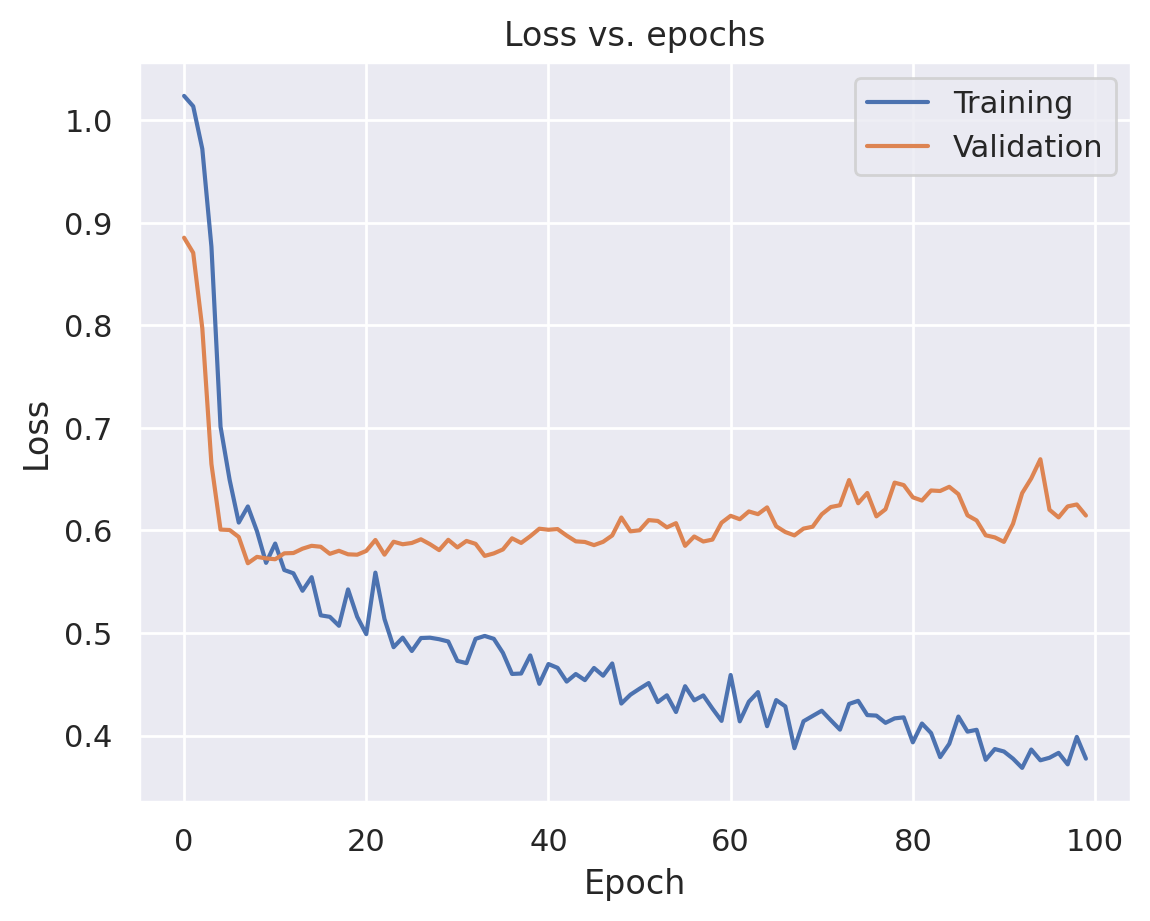

In [18]:
# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss vs. epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

In [ ]:
class my_callback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        # Do something at the start of training
        
    def on_train_batch_begin(self, batch, logs=None):
        # Do something at the start of every batch iteration
        
    def on_epoch_end(self, epoch, logs=None):
        # Do something at the end of every epoch
        
history = model.fit(X_train, y_train, 
    epochs=5, callbacks=[my_callback()]
)

#### Example training callback

In [19]:
# Write a custom callback
class TrainingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting training....")
        
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished training!")

#### Train the model with the callback

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 128)               1408      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 128)              

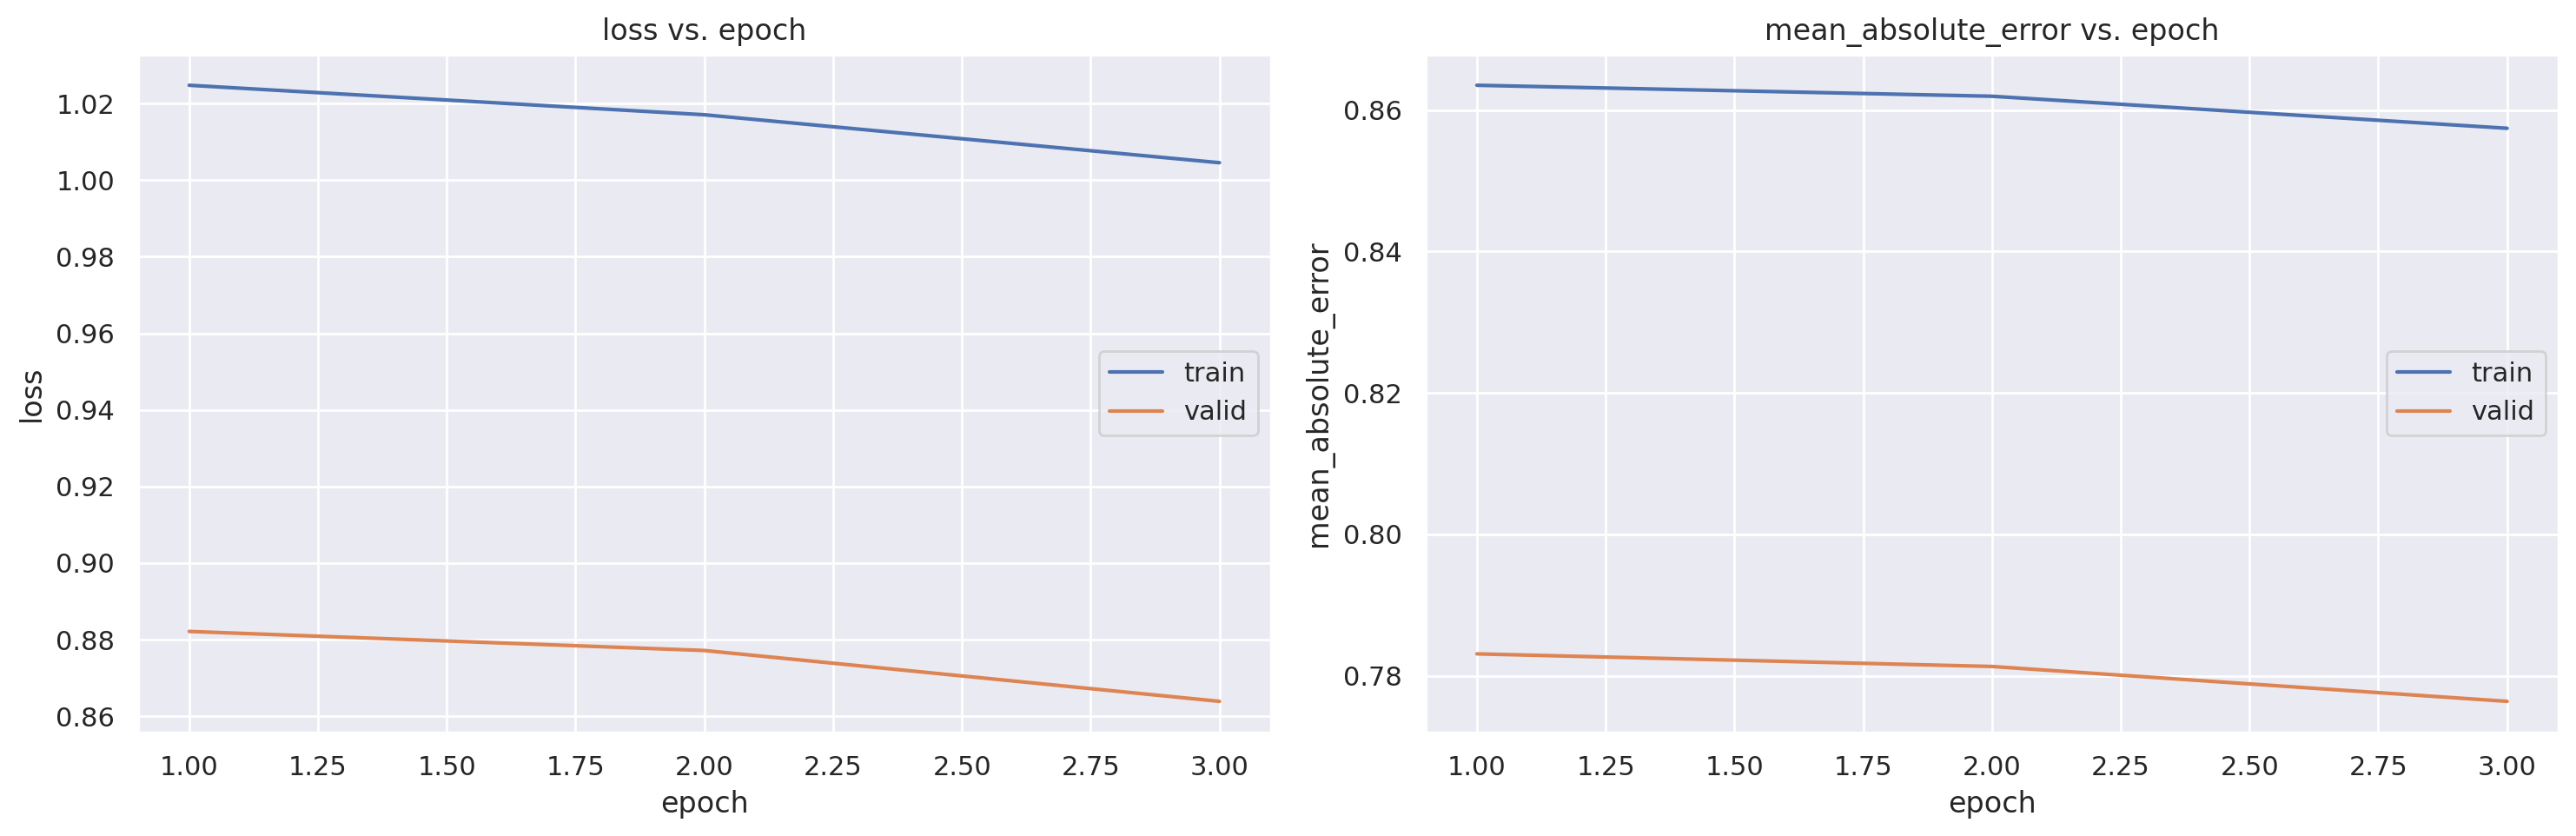

In [20]:
del model
# Re-build the model
model = get_regularised_model(input_shape=(train_data.shape[1],),
    wd=1e-5, rate=0.3)
print(model.summary())

# Compile the model
compile_model(model)
print(model.loss)
print(model.optimizer)
print(model.metrics)

# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, validation_split=0.15, 
    epochs=3, batch_size=128, verbose=0, 
    callbacks=[TrainingCallback()]
)

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error']).plot()

In [21]:
# Write a custom callback
class TestingCallback(tf.keras.callbacks.Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting testing....")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing!")

In [22]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_data, test_targets,
    verbose=0, callbacks=[TestingCallback()])
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!
Test loss: 0.994
Test MAE: 0.863


In [23]:
# Write a custom callback
class PredictionCallback(tf.keras.callbacks.Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting prediction...")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [24]:
# Make predictions with the model
preds =  model.predict(test_data,
    verbose=0, callbacks=[PredictionCallback()]
)
print(f"predictions: {np.squeeze(preds)}")

Starting prediction...
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!
predictions: [ 0.03950478  0.02157215  0.02733833  0.09569962  0.02325101  0.00444928
  0.07833188  0.05743868  0.00190374  0.01257544 -0.00866419  0.01874463
 -0.01486981  0.06148684 -0.00025009  0.00832526  0.06966739  0.07845084
  0.04045413  0.06241422  0.04550046 -0.007597   -0.01677181  0.04896336
  0.01047362  0.03244863  0.04387774  0.04277297 -0.01902556  0.01541694
  0.0416495  -0.0056852   0.02195179  0.0449568   0.06045534  0.05487509
  0.0102311   0.01712534  0.04391058 -0.0190932  -0.01675637 -0.00270863
  0.02605053  0.04914544  0.02524771]


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=5,
        activation='relu', input_shape=(128, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor='val_loss'
    monitor='val_accuracy',
    patience=5,
    min_delta=0.01,
    mode='max'
)

model.fit(X_train, y_train, validation_split=0.2, 
    epochs=100, callbacks=[early_stopping]
)

#### Re-train the models with early stopping

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 128)               1408      
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dense_34 (Dense)            (None, 1)                

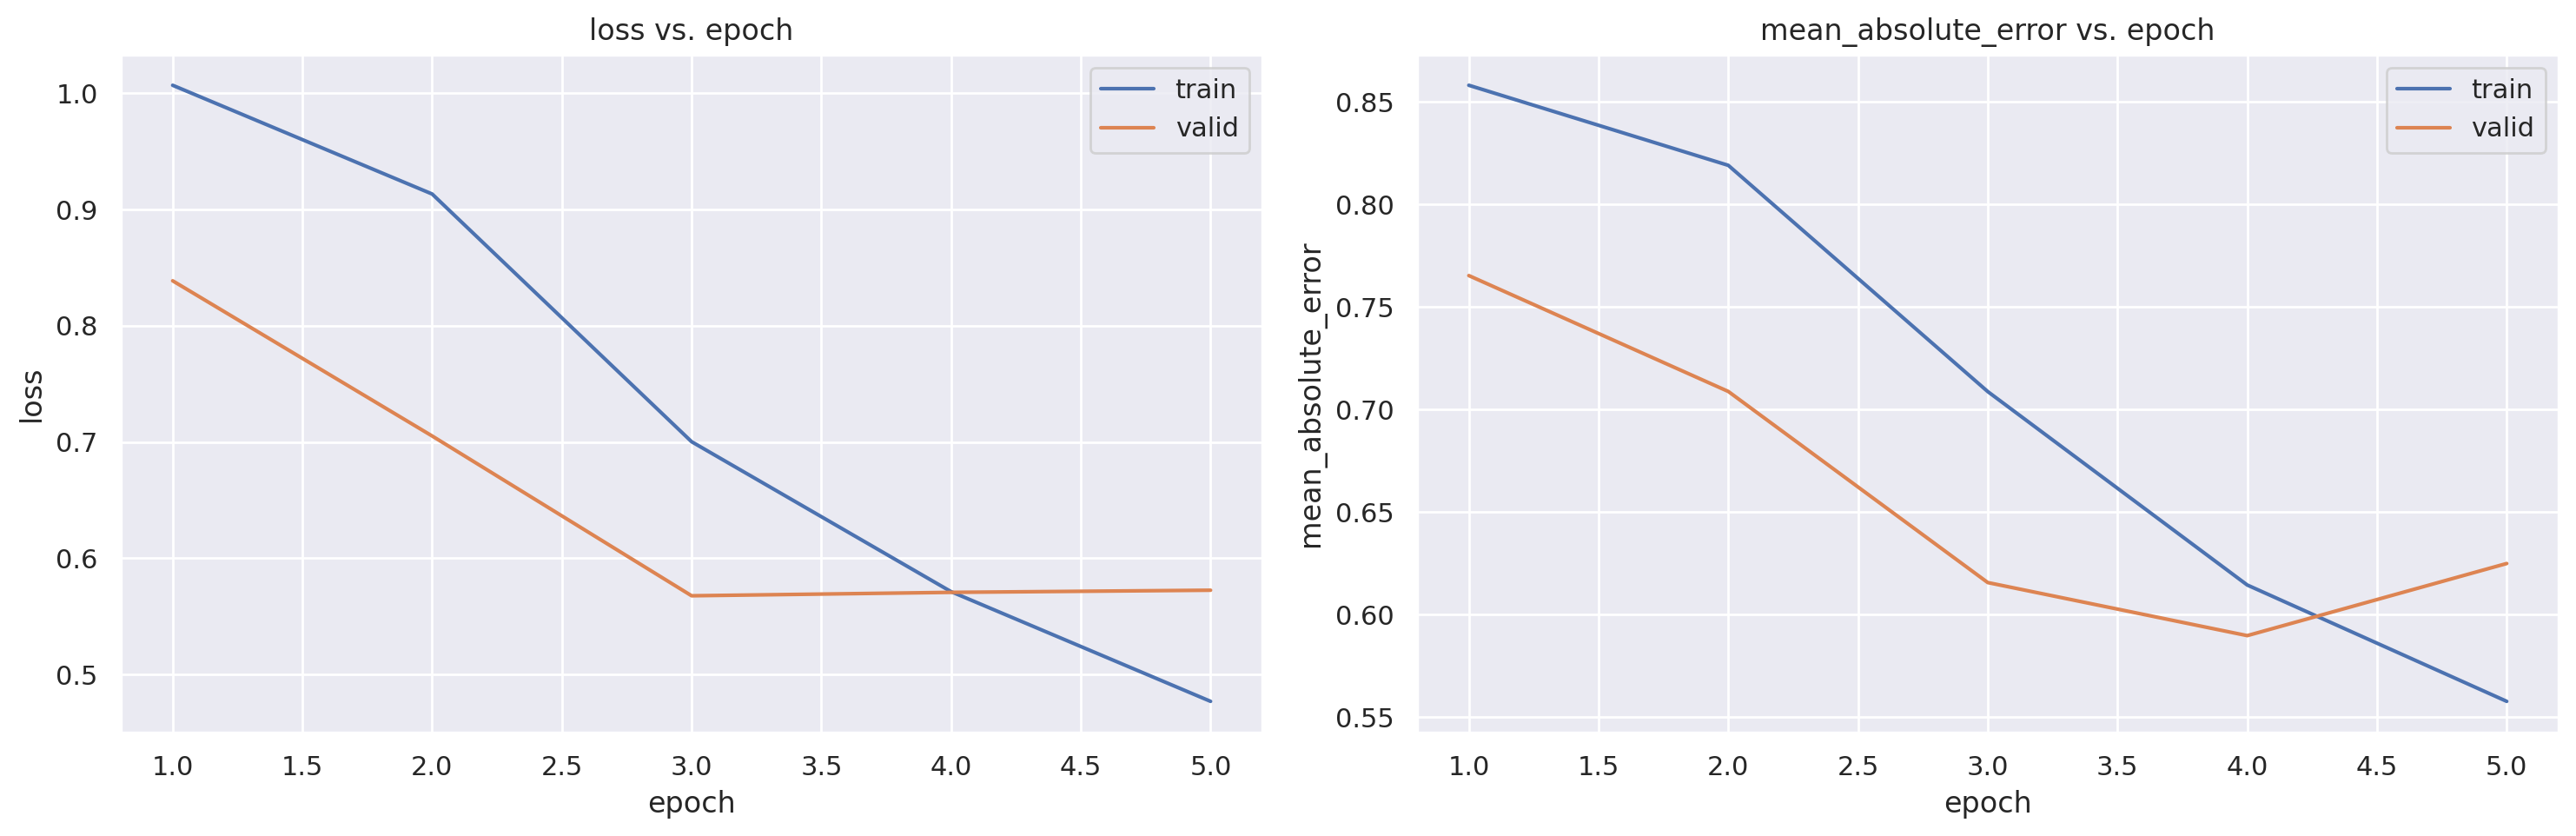

Test loss: 0.464
Test MAE: 0.539


In [25]:
# Re-train the unregularized model
unregularised_model = get_model(input_shape=(train_data.shape[1],))
# Print the model summary
print(unregularised_model.summary())

# Compile the model
compile_model(unregularised_model)
print(unregularised_model.loss)
print(unregularised_model.optimizer)
print(unregularised_model.metrics)

# Train the model, with some of the data reserved for validation
unreg_history = unregularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, epochs=100, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)
# Plot training history
PlotHistory(unreg_history, metrics=['loss', 'mean_absolute_error']).plot()

# Evaluate the model on the test set
test_loss, test_mae = unregularised_model.evaluate(test_data, test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 128)               1408      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 128)              

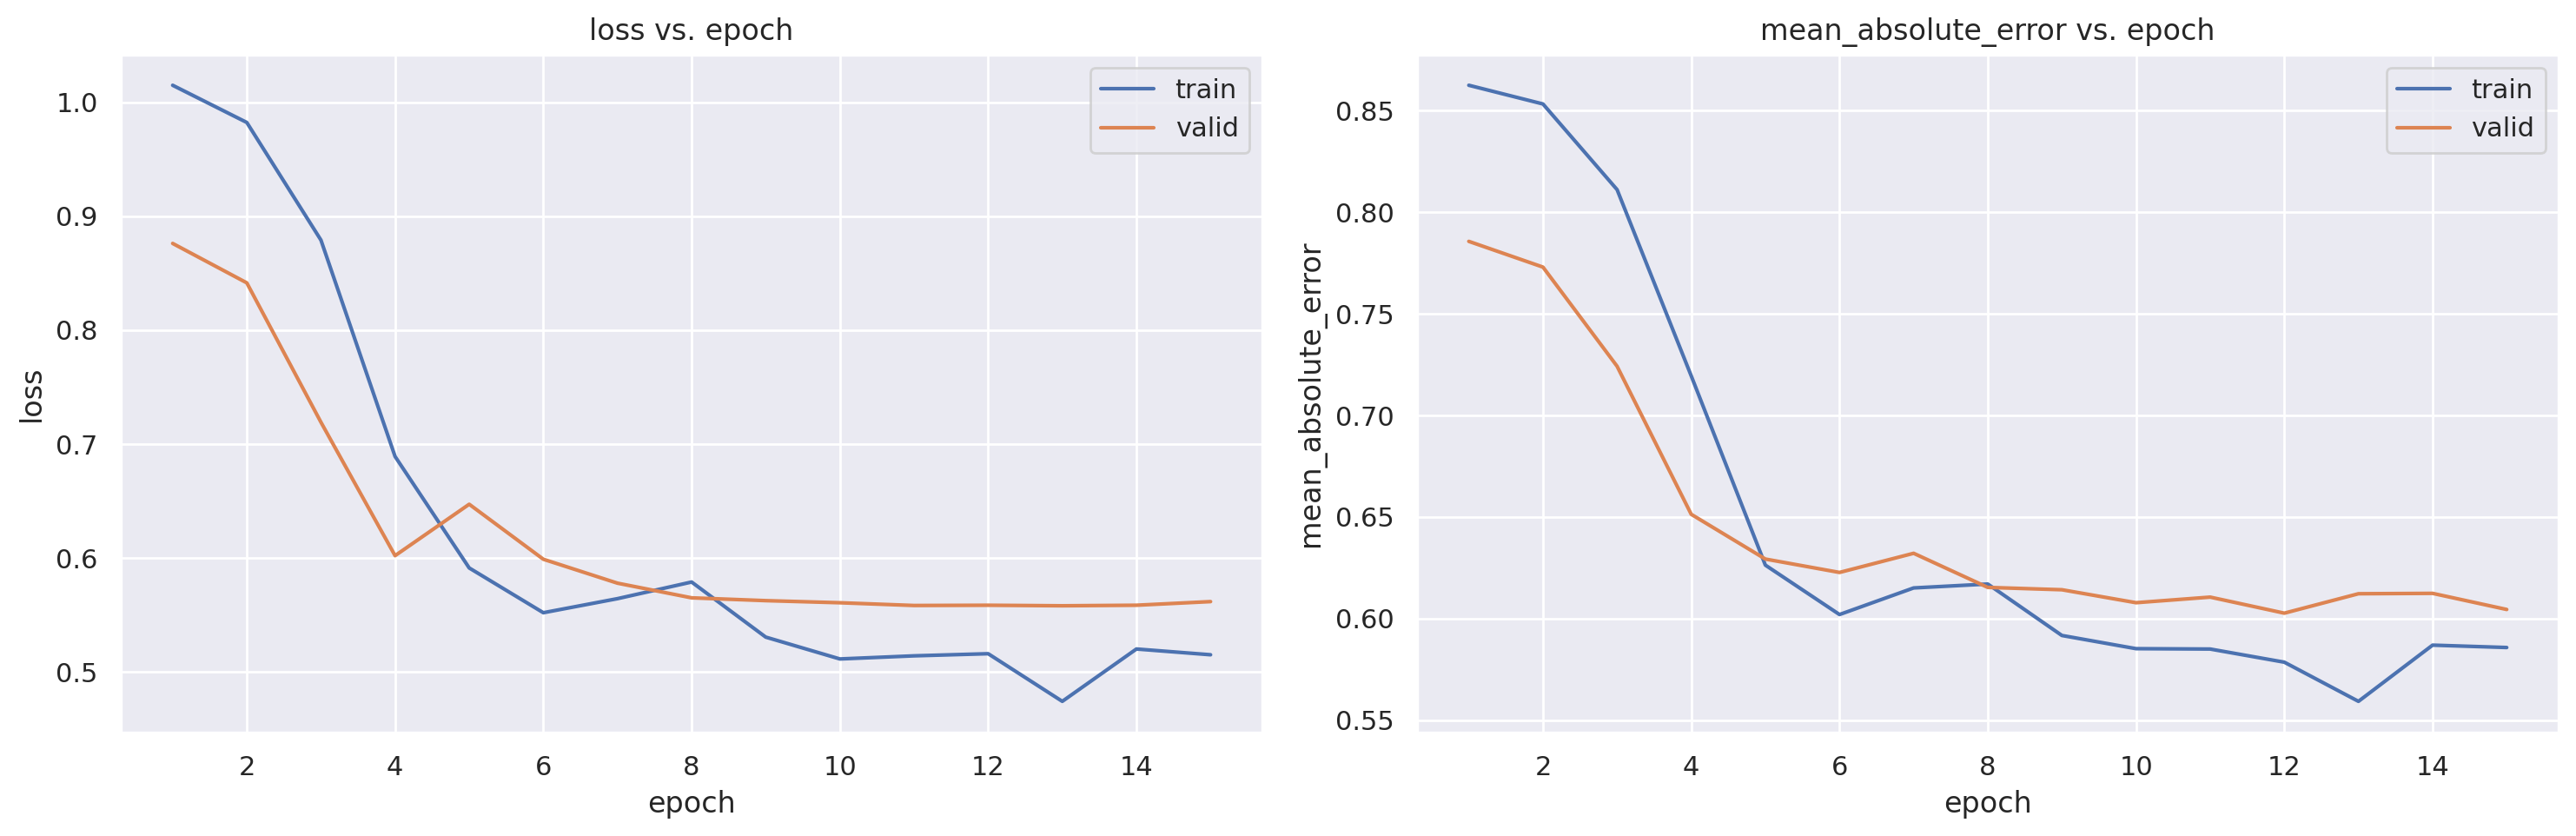

Test loss: 0.347
Test MAE: 0.465


In [26]:
# Re-train the regularised model
regularised_model = get_regularised_model(input_shape=(train_data.shape[1],),
    wd=1e-8, rate=0.2)
# Print the model summary
print(regularised_model.summary())

# Compile the model
compile_model(regularised_model)
print(regularised_model.loss)
print(regularised_model.optimizer)
print(regularised_model.metrics)

# Train the model, with some of the data reserved for validation
reg_history = regularised_model.fit(train_data, train_targets, 
    validation_split=0.15, batch_size=64, epochs=100, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)]
)
# Plot training history
PlotHistory(reg_history, metrics=['loss', 'mean_absolute_error']).plot()

# Evaluate the model on the test set
test_loss, test_mae = regularised_model.evaluate(test_data, test_targets,
    verbose=0)
print("Test loss: {:.3f}\nTest MAE: {:.3f}".format(
    test_loss, test_mae))

#### Plot the learning curves

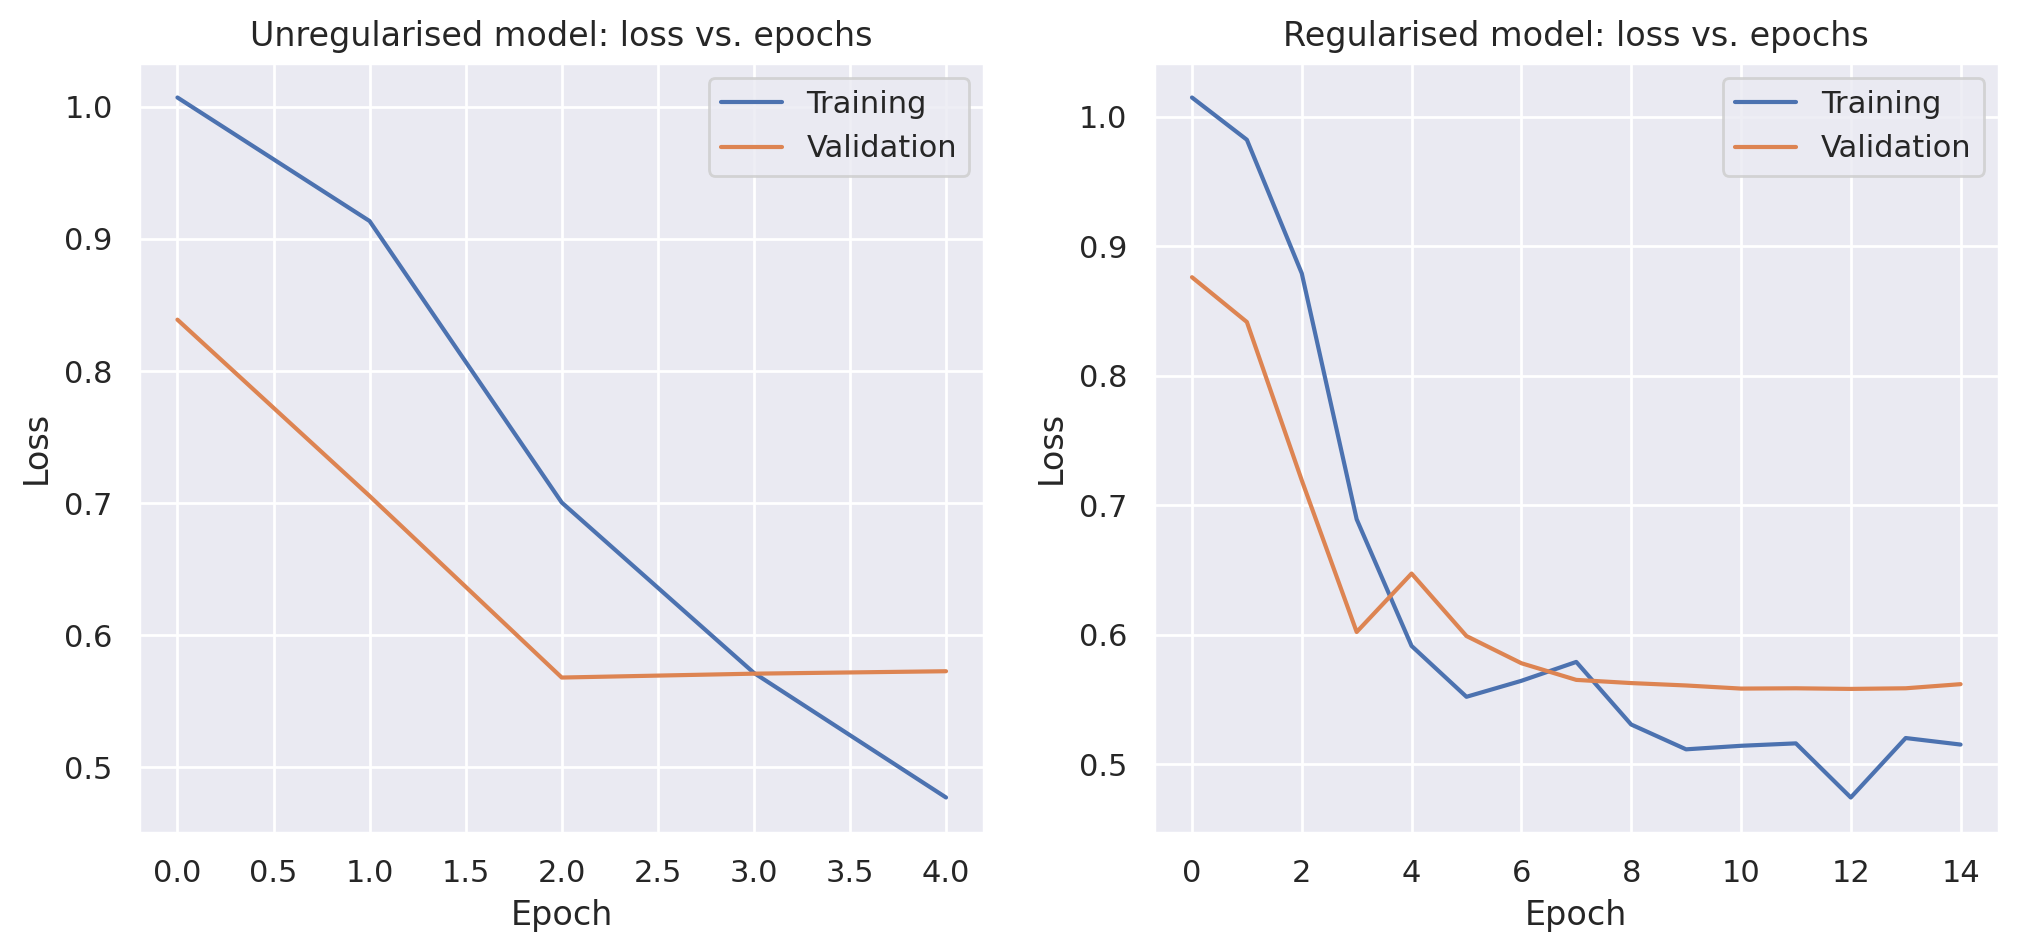

In [27]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)
plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()